In [3]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import gc

from sklearn.metrics import roc_auc_score

import lightgbm as lgbm

import pickle
def dump_pkl(data, filename):
  with open(filename, 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_pkl(filename):
  with open(filename, 'rb') as handle:
    data = pickle.load(handle)
  return data

In [6]:
df = load_pkl('data/feat_engin/lgbm/data_1hour_1day.pkl')

In [7]:
df.shape

(971600, 585)

In [9]:
df.head()

,time,ticker,index_1day,result,delta_time,income_rate,res_price,res_ind,close_w1_roc,volume_w1_roc,...,close_1day_w100_ma_low_3std/close_1day,close_1day_w100_ma_up_3std/close_1day,volume_1day_w100_ma_low_2std/volume_1day,volume_1day_w100_ma_up_2std/volume_1day,volume_1day_w100_ma_low_3std/volume_1day,volume_1day_w100_ma_up_3std/volume_1day,tmos_close_1day_w100_ma_low_2std/tmos_close_1day,tmos_close_1day_w100_ma_up_2std/tmos_close_1day,tmos_close_1day_w100_ma_low_3std/tmos_close_1day,tmos_close_1day_w100_ma_up_3std/tmos_close_1day
0,2022-05-04 18:00:00,AFLT,0.0,LOSE,1 days 16:00:00,0.98,30.379999,18,-0.000641,-0.110107,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-05-05 10:00:00,AFLT,0.0,LOSE,1 days 00:00:00,0.98,30.379999,18,0.001282,1.836605,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-05-05 11:00:00,AFLT,0.0,LOSE,1 days 01:00:00,0.98,30.280001,20,-0.008323,-0.239264,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-05-05 12:00:00,AFLT,0.0,LOSE,1 days 00:00:00,0.98,30.280001,20,-0.001937,-0.628420,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-05-05 13:00:00,AFLT,0.0,LOSE,0 days 23:00:00,0.98,30.280001,20,0.000000,-0.145421,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
df['result'].value_counts(normalize=True)

result
DNF     0.469801
LOSE    0.362670
WIN     0.167529
Name: proportion, dtype: float64

In [16]:
df['income_rate'].quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

0.00    0.980000
0.01    0.980000
0.10    0.980000
0.20    0.980000
0.30    0.980000
0.40    0.987901
0.50    0.996742
0.60    1.003665
0.70    1.012187
0.80    1.026575
0.90    1.040000
0.99    1.040000
1.00    1.040000
Name: income_rate, dtype: float64

### Change target

In [20]:
# Используем уже знакомую функцию :)

def get_target(df_all, ind, val_first, val_second, points_to_wait):
    #цель - достичь val_second, не достигнув val_first

    ind_end = min(ind+points_to_wait+1, df_all.shape[0])
    
    df = df_all.iloc[ind:ind_end].copy()
    
    mask_stock = np.array(df['ticker'] == df['ticker'].iloc[0])
    df = df.loc[mask_stock, :]

    start_price = df['close'].iloc[0]
    
    if val_first < val_second:                                 
        mask_val_first = np.array(df['close'] < val_first)
        mask_val_second = np.array(df['close'] > val_second)
    else: 
        mask_val_first = np.array(df['close'] > val_first)      ### тут будущему мне поразбираться нужно будет
        mask_val_second = np.array(df['close'] < val_second)

    
    if (mask_val_first.sum() == 0) & (mask_val_second.sum() == 0):

        ind_end = df.shape[0]-1
        delta_time = df['time'].iloc[ind_end] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_end]
        income_rate = res_price/start_price
        return 'DNF', delta_time, income_rate, res_price, ind_end+ind
        
    if (mask_val_first.sum() == 0) & (mask_val_second.sum() != 0):
        ind_val_second = np.argwhere(mask_val_second).ravel()[0]
        delta_time = df['time'].iloc[ind_val_second] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_val_second]
        income_rate = res_price/start_price
        return 'WIN', delta_time, income_rate, res_price, ind_val_second+ind
        
    if (mask_val_first.sum() != 0) & (mask_val_second.sum() == 0):
        ind_val_first = np.argwhere(mask_val_first).ravel()[0]
        delta_time = df['time'].iloc[ind_val_first] - df['time'].iloc[0]
        res_price = df['close'].iloc[ind_val_first]
        income_rate = res_price/start_price
        return 'LOSE', delta_time, income_rate, res_price, ind_val_first+ind

    if (mask_val_first.sum() != 0) & (mask_val_second.sum() != 0):
        ind_val_first = np.argwhere(mask_val_first).ravel()[0]
        ind_val_second = np.argwhere(mask_val_second).ravel()[0]
        if ind_val_first < ind_val_second:
            delta_time = df['time'].iloc[ind_val_first] - df['time'].iloc[0]
            res_price = df['close'].iloc[ind_val_first]
            income_rate = res_price/start_price
            return 'LOSE', delta_time, income_rate, res_price, ind_val_first+ind
        if ind_val_first > ind_val_second:
            delta_time = df['time'].iloc[ind_val_second] - df['time'].iloc[0]
            res_price = df['close'].iloc[ind_val_second]
            income_rate = res_price/start_price
            return 'WIN', delta_time, income_rate, res_price, ind_val_second+ind


def get_df_target(df, indx, percent_first=None, percent_second=None, points_to_wait=None):
    times = []
    results = []
    delta_times = []
    income_rates = []
    closes = []
    tickers = []
    res_prices = []
    res_inds = []
    
    #for ind in indx:
    for ind in tqdm(indx):
        time = df['time'].iloc[ind]
        close = df['close'].iloc[ind]
        ticker = df['ticker'].iloc[ind]
        
        val_first = df['close'].iloc[ind] * percent_first
        val_second = df['close'].iloc[ind] * percent_second
        result, delta_time, income_rate, res_price, res_ind = get_target(df, ind, val_first, val_second, points_to_wait)
        
        times += [time]
        closes += [close]
        tickers += [ticker]
        results += [result]
        delta_times += [delta_time]
        income_rates += [income_rate]
        res_prices += [res_price]
        res_inds += [res_ind]
        

    df_result = pd.DataFrame({'ind' : indx,
                              'time' : times,
                              'close' : closes,
                              'result' : results,
                              'ticker' : tickers, 
                              'delta_time' : delta_times,
                              'income_rate' : income_rates,
                              'res_price' : res_prices,
                              'res_ind' : res_inds
                             })
    return df_result    

In [22]:
df_result = load_pkl('./data/feat_engin/lgbm/df_result_wait_14_2days.pkl')
df_result = df_result[['time', 'close', 'ticker']]
df_result

,time,close,ticker
0,2022-05-04 10:00:00,32.100,AFLT
1,2022-05-04 11:00:00,31.380,AFLT
2,2022-05-04 12:00:00,31.800,AFLT
3,2022-05-04 13:00:00,31.360,AFLT
4,2022-05-04 14:00:00,31.540,AFLT
...,...,...,...
972606,2024-12-31 19:00:00,10.830,RBCM
972607,2024-12-31 20:00:00,10.775,RBCM
972608,2024-12-31 21:00:00,10.820,RBCM
972609,2024-12-31 22:00:00,10.765,RBCM


In [24]:
inds = np.arange(df_result.shape[0])
inds.shape

(972611,)

In [26]:
df_result = get_df_target(df_result, inds, percent_first=0.98, percent_second=1.04, points_to_wait=14*3)
df_result["income_rate"] = np.maximum(df_result["income_rate"], 0.98)
df_result["income_rate"] = np.minimum(df_result["income_rate"], 1.04)

100%|███████████████████████████████████████████████████████████████| 972611/972611 [03:49<00:00, 4245.40it/s]


In [27]:
df_result['result'].value_counts(normalize=True)

result
LOSE    0.433907
DNF     0.343867
WIN     0.222226
Name: proportion, dtype: float64

In [28]:
df_result['income_rate'].quantile(q=[0, 0.01]+np.arange(0.1, 1, 0.1).tolist()+[0.99, 1])

0.00    0.980000
0.01    0.980000
0.10    0.980000
0.20    0.980000
0.30    0.980000
0.40    0.980000
0.50    0.993719
0.60    1.004109
0.70    1.016569
0.80    1.040000
0.90    1.040000
0.99    1.040000
1.00    1.040000
Name: income_rate, dtype: float64

In [29]:
(df_result['ind'] == df_result.index).all(), 

(True,)

In [30]:
df_result = df_result[['time','result', 'ticker', 'delta_time', 'income_rate',
       'res_price', 'res_ind']]

In [31]:
df.shape

(971600, 585)

In [32]:
#join
df = df[df.columns[~df.columns.isin(['result', 'delta_time', 'income_rate', 'res_price', 'res_ind'])]].merge(
    df_result, how='inner', on=['time', 'ticker'])
df.shape

(971600, 585)

### 1. train/valid/test/test2 split

In [35]:
df['target'] = (df['result'] == 'WIN').astype(int)

<Axes: xlabel='time'>

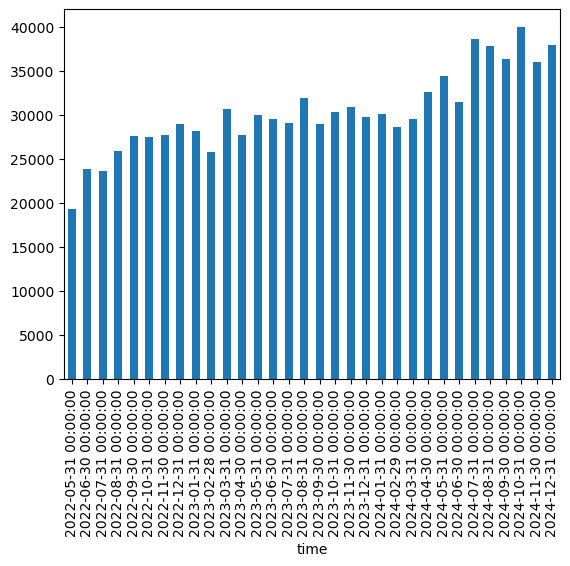

In [36]:
df[['time', 'target']].groupby(pd.Grouper(key='time', freq='ME')).target.count().plot.bar()

<Axes: xlabel='time'>

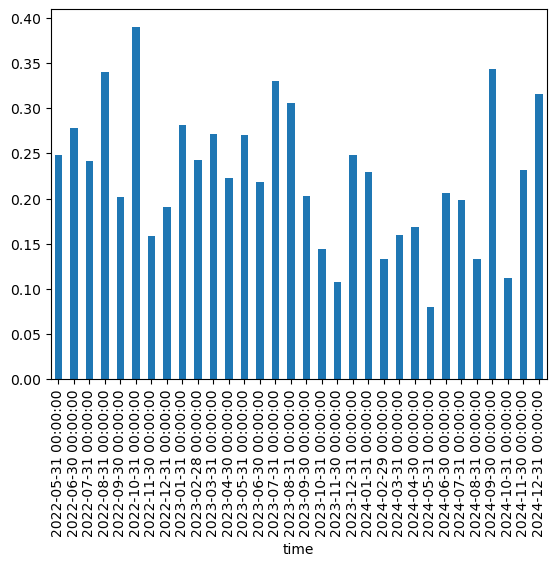

In [37]:
df[['time', 'target']].groupby(pd.Grouper(key='time', freq='ME')).target.mean().plot.bar()

<Axes: xlabel='time'>

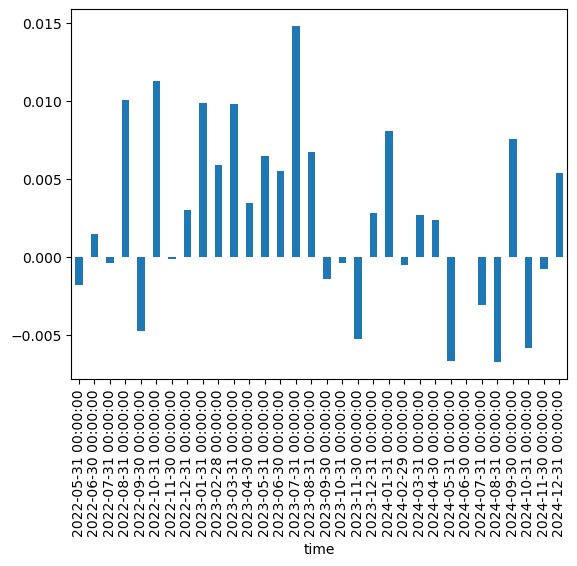

In [38]:
(df[['time', 'income_rate']].groupby(pd.Grouper(key='time', freq='ME')).income_rate.mean()-1).plot.bar()

In [40]:
pd.set_option('display.max_rows', 150)
df[['ticker', 'target']].groupby('ticker').target.mean().sort_values()

ticker
PHOR       0.097052
IRAO       0.098350
HYDR       0.108294
MTSS       0.112579
GMKN       0.114725
SBERP      0.115406
GAZP       0.115947
SBER       0.119664
CBOM       0.124190
LKOH       0.125764
ROSN       0.129472
AKRN       0.131808
TATNP      0.135832
RTKM       0.137912
TATN       0.140860
TRNFP      0.141929
VSMO       0.142213
RTKMP      0.145813
NVTK       0.147194
RUAL       0.147958
ALRS       0.148031
MAGN       0.150213
SGZH       0.153468
MOEX       0.156148
MGNT       0.160358
PLZL       0.161713
VTBR       0.161829
BELU       0.165404
SMLT       0.166960
SNGSP      0.168577
PIKK       0.171853
SIBN       0.173129
CHMF       0.173866
OGKB       0.175680
POSI       0.175809
UPRO       0.182319
ENPG       0.186318
NLMK       0.190684
KRKNP      0.195027
T          0.195640
SNGS       0.196046
KAZT       0.196218
AQUA       0.197943
AFKS       0.198187
APTK       0.200204
FEES       0.202334
AFLT       0.207009
LSNGP      0.208035
MVID       0.214947
MSNG       0.

In [41]:
df[['ticker', 'income_rate']].groupby('ticker').income_rate.mean().sort_values()

ticker
VSMO       0.997728
SGZH       0.999043
YAKG       0.999085
HYDR       0.999534
VEON-RX    0.999851
RKKE       1.000050
LNZL       1.000069
SMLT       1.000092
IRKT       1.000117
RUAL       1.000195
GMKN       1.000307
GAZP       1.000337
PHOR       1.000383
LNZLP      1.000556
KMAZ       1.000565
ROLO       1.000573
APTK       1.000633
KAZT       1.000671
ENPG       1.000684
NVTK       1.000694
VTBR       1.000790
UNAC       1.000886
PIKK       1.000930
ABIO       1.000950
SPBE       1.001059
KAZTP      1.001150
MRKS       1.001165
GTRK       1.001244
LENT       1.001247
WUSH       1.001268
UNKL       1.001298
TGKBP      1.001340
MTLRP      1.001355
ALRS       1.001366
MGTSP      1.001405
VKCO       1.001452
LIFE       1.001452
MVID       1.001457
KZOSP      1.001488
CNTLP      1.001492
RTKMP      1.001493
OGKB       1.001508
MTLR       1.001542
TRNFP      1.001589
KRKNP      1.001688
T          1.001690
RTKM       1.001727
MTSS       1.001741
KZOS       1.001741
UWGN       1.

In [43]:
mask_train = np.array((pd.Timestamp('2022-01-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-07-01')))
mask_valid = np.array((pd.Timestamp('2024-07-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-09-01')))
mask_test = np.array((pd.Timestamp('2024-09-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-11-01')))
mask_test2 = np.array((pd.Timestamp('2024-11-01') <= df['time']) & (df['time'] < pd.Timestamp('2024-12-23')))
#mask_test2 = mask_test

In [44]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(744713, 76495, 76398, 61912)

In [46]:
# некоторые акции имеют более короткую историю
NEED_POINTS = 102
mask_avbl_all = np.zeros_like(mask_train).astype(bool)
for ticker in df["ticker"].unique():
    mask = np.array(df['ticker'] == ticker)
    count_days = df.loc[mask, 'time'].dt.date.nunique()
    if count_days < NEED_POINTS:
        mask_avbl = np.zeros_like(mask_train).astype(bool)
    else:
        date_first_avbl =  np.sort(df.loc[mask, 'time'].dt.date.unique())[NEED_POINTS]
        #print(date_first_avbl)
        mask_avbl = np.array(df["time"] >= pd.to_datetime(date_first_avbl))
    
    mask_ticker = np.array(df['ticker'] == ticker)
    mask_avbl_ticker = mask_ticker & mask_avbl

    mask_avbl_all |= mask_avbl_ticker

mask_train &= mask_avbl_all
mask_valid &= mask_avbl_all
mask_test &= mask_avbl_all
mask_test2 &= mask_avbl_all


#мб дату неправильно обрезаю

In [47]:
mask_train.sum(), mask_valid.sum(), mask_test.sum(), mask_test2.sum()

(627417, 76495, 76398, 61912)

In [48]:
mask_data = mask_train|mask_valid|mask_test|mask_test2
(mask_data).sum()

842222

In [49]:
df.loc[mask_data].isnull().sum()[df.loc[mask_data].isnull().sum() > 0].sort_values()

Series([], dtype: int64)

In [52]:
mask_train.sum()/(mask_data).sum(), mask_valid.sum()/(mask_data).sum(), mask_test.sum()/(mask_data).sum(), mask_test2.sum()/(mask_data).sum()

(0.7449544181937778,
 0.09082522185362055,
 0.0907100503192745,
 0.07351030963332708)

In [53]:
df.loc[mask_train, 'target'].mean(), df.loc[mask_valid, 'target'].mean(), df.loc[mask_test, 'target'].mean(), df.loc[mask_test2, 'target'].mean()

(0.21596641468114508,
 0.1655794496372312,
 0.2221262336710385,
 0.25990115001938235)

In [54]:
df.loc[mask_train, 'income_rate'].mean(), df.loc[mask_valid, 'income_rate'].mean(), df.loc[mask_test, 'income_rate'].mean(), df.loc[mask_test2, 'income_rate'].mean()

(1.0035898032465713,
 0.9951242910647521,
 1.0005698721790353,
 1.0003889993897253)

In [56]:
#проверки

In [57]:
(mask_train.sum()+mask_valid.sum()+mask_test.sum()+mask_test2.sum()) ==(mask_data).sum()

#(mask_train.sum()+mask_valid.sum()+mask_test.sum()) ==(mask_data).sum()

True

## 3. Model

### 3.1 Base model

In [61]:
df['ticker_code'] = df['ticker'].astype('category').cat.codes

In [62]:
df['ticker_code'].nunique()

127

In [63]:
df.loc[mask_train, 'ticker_code'].nunique()

127

In [64]:
df.columns.tolist()

['time',
 'ticker',
 'index_1day',
 'close_w1_roc',
 'volume_w1_roc',
 'tmos_close_w1_roc',
 'close_w5_norm_std',
 'close_w5_mean_abs_pct',
 'close_w5_alpha',
 'close_w5_rsi',
 'close_w5_roc',
 'volume_w5_norm_std',
 'volume_w5_mean_abs_pct',
 'volume_w5_alpha',
 'volume_w5_rsi',
 'volume_w5_roc',
 'tmos_close_w5_norm_std',
 'tmos_close_w5_mean_abs_pct',
 'tmos_close_w5_alpha',
 'tmos_close_w5_rsi',
 'tmos_close_w5_roc',
 'close_w14_norm_std',
 'close_w14_mean_abs_pct',
 'close_w14_alpha',
 'close_w14_rsi',
 'close_w14_roc',
 'volume_w14_norm_std',
 'volume_w14_mean_abs_pct',
 'volume_w14_alpha',
 'volume_w14_rsi',
 'volume_w14_roc',
 'tmos_close_w14_norm_std',
 'tmos_close_w14_mean_abs_pct',
 'tmos_close_w14_alpha',
 'tmos_close_w14_rsi',
 'tmos_close_w14_roc',
 'close_w70_norm_std',
 'close_w70_mean_abs_pct',
 'close_w70_alpha',
 'close_w70_rsi',
 'close_w70_roc',
 'close_w70_lvl_1-1.01',
 'close_w70_lvl_-0.99-1',
 'close_w70_lvl_1.01-1.02',
 'close_w70_lvl_-0.98-0.99',
 'close_w70_l

In [65]:
drop_cols = ['time',
             #'ticker_code',
             #'hour', 'day', 'weekday', 

 'ticker',
 'index_1day',
 'result',
 'delta_time',
 'income_rate',
 'res_price',
 'res_ind', 'index', 'target', 
              'ind', 'close',
             'y_pred'] #+ [elem for elem in df.columns if 'roc' in elem]


features = df.columns[~df.columns.isin(drop_cols)].tolist()
#features = [elem for elem in df.columns if (('/' in elem) or ('lvl' in elem) or ('alpha' in elem))] +['hour', 'day', 'weekday'] + #['ticker_code']
                                                                                                    


cat_features_all = ['ticker_code',
                'hour', 'day', 'weekday',# 'month'
]
cat_features = cat_features_all

target = 'target'

### Get stability features

In [70]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    
    "num_leaves": 2,

     "bagging_fraction": 0.5,
     "bagging_freq": 1,
     "verbose": -1,
    "metric": "auc",
    "early_stopping" : 20, 
}

auc_features = {'feature' : [],
               'auc_train' : [],
               'auc_valid' : [],
               'auc_test' : [],
               'auc_test2' : []
               }

for feature in tqdm(features):
    stab_features = [feature]
    stab_cat_features = [feature] if feature in cat_features else []
    
    D_train = lgbm.Dataset(df.loc[mask_train, stab_features], label=df.loc[mask_train, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)
    D_valid = lgbm.Dataset(df.loc[mask_valid, stab_features], label=df.loc[mask_valid, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)
    D_test = lgbm.Dataset(df.loc[mask_test, stab_features], label=df.loc[mask_test, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)
    D_test2 = lgbm.Dataset(df.loc[mask_test2, stab_features], label=df.loc[mask_test2, target], feature_name=stab_features, categorical_feature=stab_cat_features, free_raw_data=False)
        
    model = lgbm.train(params, num_boost_round=1_000, train_set=D_train, valid_sets=[D_valid])
    
    y_pred_train = model.predict(D_train.data)
    y_pred_valid = model.predict(D_valid.data)
    y_pred_test = model.predict(D_test.data)
    y_pred_test2 = model.predict(D_test2.data)

    auc_features['feature'] += [feature]
    auc_features['auc_train'] += [roc_auc_score(D_train.label, y_pred_train)]
    auc_features['auc_valid'] += [roc_auc_score(D_valid.label, y_pred_valid)]
    auc_features['auc_test'] += [roc_auc_score(D_test.label, y_pred_test)]
    auc_features['auc_test2'] += [roc_auc_score(D_test2.label, y_pred_test2)]

auc_features_cp = auc_features.copy()

100%|███████████████████████████████████████████████████████████████████████| 577/577 [03:39<00:00,  2.62it/s]


In [71]:
df_auc_features = pd.DataFrame(auc_features)
df_auc_features.sort_values('auc_valid', ascending=False)

,feature,auc_train,auc_valid,auc_test,auc_test2
34,close_w70_mean_abs_pct,0.642968,0.681694,0.659560,0.524026
574,tmos_close_1day_w100_ma_low_3std/tmos_close_1day,0.560024,0.663179,0.597305,0.693545
256,close_1day_w20_norm_std,0.606113,0.642859,0.639685,0.537319
555,close_1day_w20_ma_up_3std/close_1day,0.565919,0.638321,0.650665,0.586923
242,close_1day_w5_mean_abs_pct,0.584187,0.638239,0.646458,0.534049
...,...,...,...,...,...
240,tmos_close_1day_w3_roc,0.563706,0.469701,0.556556,0.488366
292,tmos_close_1day_w20_lvl_-0.96-0.97,0.524715,0.466789,0.532414,0.418490
414,tmos_close_1day_w3_mean_abs_pct/tmos_close_1da...,0.514887,0.459177,0.534058,0.500000
77,day,0.528861,0.455617,0.518650,0.418901


#### auc <=0.525

In [74]:
auc_treshold = 0.525

In [75]:
mask_auc_train  = df_auc_features['auc_train'] <= auc_treshold 
mask_auc_train.sum()

197

In [76]:
mask_auc_valid  = df_auc_features['auc_valid'] <= auc_treshold 
mask_auc_valid.sum()

251

In [77]:
mask_auc_test  = df_auc_features['auc_test'] <= auc_treshold 
mask_auc_test.sum()

306

In [78]:
(mask_auc_train | mask_auc_valid | mask_auc_test).sum()

383

In [80]:
mask_auc_test2  = df_auc_features['auc_test2'] <= auc_treshold 
mask_auc_test2.sum()

383

In [81]:
(mask_auc_train | mask_auc_valid | mask_auc_test | mask_auc_test2).sum()

443

#### delta_auc > 0.05

In [85]:
auc_delta_treshold  = 0.025

In [86]:
mask_auc_delta_valid = (df_auc_features['auc_train'] - df_auc_features['auc_valid']).abs() > auc_delta_treshold
mask_auc_delta_valid.sum()

156

In [87]:
mask_auc_delta_test = (df_auc_features['auc_train'] - df_auc_features['auc_test']).abs() > auc_delta_treshold
mask_auc_delta_test.sum()

268

In [88]:
(mask_auc_delta_valid | mask_auc_delta_test).sum()

326

In [90]:
mask_auc_delta_test2 = (df_auc_features['auc_train'] - df_auc_features['auc_test2']).abs() > auc_delta_treshold
mask_auc_delta_test2.sum()

331

In [91]:
(mask_auc_delta_valid | mask_auc_delta_test | mask_auc_delta_test2).sum()

425

#### union criterias

In [94]:
mask_criterias1 = mask_auc_train | mask_auc_valid | mask_auc_test | mask_auc_delta_valid | mask_auc_delta_valid | mask_auc_delta_test
mask_criterias1.sum()

499

In [95]:
mask_criterias2 = mask_criterias1 | mask_auc_test2 | mask_auc_delta_test2
mask_criterias2.sum()

543

In [97]:
features_criteria1 = df_auc_features['feature'].values[~mask_criterias1]
len(features_criteria1), features_criteria1

(78,
 array(['close_w1_roc', 'close_w5_norm_std', 'close_w5_mean_abs_pct',
        'close_w5_roc', 'tmos_close_w5_norm_std', 'tmos_close_w5_roc',
        'close_w14_norm_std', 'close_w14_mean_abs_pct', 'close_w14_roc',
        'tmos_close_w14_alpha', 'close_w70_roc', 'close_w70_lvl_1-1.01',
        'close_w70_lvl_-0.98-0.99', 'close_w70_lvl_1.02-1.03',
        'close_w70_lvl_-0.97-0.98', 'close_w70_lvl_1.03-1.04',
        'close_w70_lvl_-0.96-0.97', 'close_w70_lvl_1.04-1.05',
        'close_w70_lvl_-0.95-0.96', 'close_w70_lvl_1.05-1.07',
        'close_w70_lvl_-0.9299999999999999-0.95', 'close_w70_lvl_1.07-1.1',
        'tmos_close_w70_mean_abs_pct',
        'tmos_close_w1_roc/tmos_close_w14_alpha',
        'tmos_close_w1_roc/tmos_close_w70_alpha', 'close/close_w5_ma',
        'close/close_w14_ma', 'close/close_w70_ma',
        'close_w5_ma/close_w14_ma', 'close_w5_ma/close_w70_ma',
        'close_w14_ma/close_w70_ma', 'tmos_close/tmos_close_w5_ma',
        'tmos_close/tmos_close_w14_m

In [98]:
df_auc_features.loc[df_auc_features['feature'].isin(features_criteria1)].sort_values('auc_valid', ascending=False)

,feature,auc_train,auc_valid,auc_test,auc_test2
19,close_w14_mean_abs_pct,0.616105,0.630970,0.631153,0.586136
479,close_1day_w3_ma/close_1day_w20_ma,0.602080,0.608239,0.582230,0.582062
58,tmos_close_w70_mean_abs_pct,0.595402,0.604386,0.590576,0.409517
4,close_w5_mean_abs_pct,0.598332,0.597819,0.591944,0.563081
260,close_1day_w20_roc,0.586760,0.596463,0.586114,0.581432
18,close_w14_norm_std,0.593143,0.594616,0.603794,0.570225
211,close_w70_ma_low_2std/close,0.597887,0.593465,0.594112,0.544300
476,close_1day/close_1day_w20_ma,0.582756,0.590709,0.576722,0.573247
299,close_1day_w100_norm_std,0.598690,0.587067,0.598702,0.547920
201,close_w14_ma_low_3std/close,0.585178,0.585905,0.587366,0.594270


In [100]:
features_criteria2 = df_auc_features['feature'].values[~mask_criterias2]
len(features_criteria2), features_criteria2

(34,
 array(['close_w5_roc', 'tmos_close_w5_norm_std', 'tmos_close_w5_roc',
        'close_w14_norm_std', 'close_w14_roc', 'close_w70_lvl_1-1.01',
        'close_w70_lvl_1.02-1.03',
        'tmos_close_w1_roc/tmos_close_w70_alpha', 'close/close_w5_ma',
        'close/close_w14_ma', 'close/close_w70_ma',
        'close_w5_ma/close_w14_ma', 'close_w5_ma/close_w70_ma',
        'close_w14_ma/close_w70_ma', 'tmos_close/tmos_close_w5_ma',
        'tmos_close/tmos_close_w14_ma', 'close_w14_min/close',
        'close_w70_max/close', 'close_w5_ma_low_2std/close',
        'tmos_close_w5_ma_low_2std/tmos_close',
        'tmos_close_w5_ma_low_3std/tmos_close',
        'close_w14_ma_low_2std/close', 'close_w14_ma_low_3std/close',
        'close_w70_ma_up_2std/close', 'close_1day_w20_roc',
        'close_1day_w20_lvl_1-1.01', 'close_1day_w20_lvl_1.01-1.02',
        'close_1day_w20_lvl_1.02-1.03', 'close_1day_w20_lvl_1.03-1.04',
        'close_1day_w100_roc',
        'tmos_close_1day_w5_roc/tmos_clos

In [101]:
df_auc_features.loc[df_auc_features['feature'].isin(features_criteria2)].sort_values('auc_valid', ascending=False)

,feature,auc_train,auc_valid,auc_test,auc_test2
479,close_1day_w3_ma/close_1day_w20_ma,0.602080,0.608239,0.582230,0.582062
260,close_1day_w20_roc,0.586760,0.596463,0.586114,0.581432
18,close_w14_norm_std,0.593143,0.594616,0.603794,0.570225
476,close_1day/close_1day_w20_ma,0.582756,0.590709,0.576722,0.573247
201,close_w14_ma_low_3std/close,0.585178,0.585905,0.587366,0.594270
153,close/close_w70_ma,0.584756,0.585241,0.586171,0.561859
155,close_w5_ma/close_w70_ma,0.583435,0.584508,0.590036,0.561527
156,close_w14_ma/close_w70_ma,0.578839,0.579709,0.597539,0.558520
261,close_1day_w20_lvl_1-1.01,0.558204,0.576937,0.563321,0.575795
199,close_w14_ma_low_2std/close,0.577033,0.571651,0.571286,0.590594


In [103]:
features = features_criteria2.tolist()
cat_features = [feature for feature in features if feature in cat_features_all]

In [104]:
len(features), len(cat_features)

(34, 0)

In [105]:
'ticker_code' in features

False

In [106]:
D_train = lgbm.Dataset(df.loc[mask_train, features], label=df.loc[mask_train, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, features], label=df.loc[mask_valid, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, features], label=df.loc[mask_test, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, features], label=df.loc[mask_test2, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)


D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

In [259]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    
    
    "num_boost_round" : 1_000,

    
    "num_leaves": 4,
    #"learning_rate": 0.001,
     "feature_fraction": 0.3,
     "bagging_fraction": 0.3,
     "bagging_freq": 1,
    'lambda_l1' : 0.1,
    'lambda_l2' : 0.1,
    #"verbose": 0,

    #'max_bin' : 1000000,
    
    
    "metric": "auc",
    #"metric" : 'mean_income_rate',
    "early_stopping" : 50,



    
}

def mean_income_rate(y_pred, data):
    q = 0.99
    mask = y_pred >= np.quantile(y_pred, q)
    score = round(data.income_rate[mask].mean(), 5)
    
    return 'mean_income_rate', score, True#is_higher_better
    

model = lgbm.train(params, train_set=D_train, valid_sets=[D_valid], feval=mean_income_rate, )

/opt/anaconda3/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[17]	valid_0's auc: 0.629277	valid_0's mean_income_rate: 1.01104


In [261]:
model.num_trees()

17

In [264]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)
y_pred_test2 = model.predict(D_test2.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test), roc_auc_score(D_test2.label, y_pred_test2)


(0.6400193934907861,
 0.6292767988719821,
 0.6322959389233735,
 0.5978317140690098)

In [266]:
#свой threshold

q = 0.98

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())


Valid
result
LOSE    0.578837
WIN     0.376637
DNF     0.044526
Name: proportion, dtype: float64
1.0038585746637947

Test
result
LOSE    0.487132
WIN     0.454044
DNF     0.058824
Name: proportion, dtype: float64
1.0087229853737765

Test2
result
WIN     0.501337
LOSE    0.428476
DNF     0.070187
Name: proportion, dtype: float64
1.0117063634096337


In [239]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 19:00:00'),
 Timedelta('0 days 19:00:00'),
 Timedelta('0 days 17:00:00'))

In [241]:
mask_win = df['result'] == 'WIN'
df.loc[mask_valid&mask&mask_win, 'delta_time'].median(), df.loc[mask_test&mask&mask_win, 'delta_time'].median(), df.loc[mask_test2&mask&mask_win, 'delta_time'].median()

(Timedelta('0 days 17:00:00'),
 Timedelta('0 days 23:00:00'),
 Timedelta('0 days 17:00:00'))

In [244]:
#общий threshold

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshokd = {threshold}')

mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('\nTetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())

threshokd = 0.4244263117330449

Valid
result
LOSE    0.480392
WIN     0.451634
DNF     0.067974
Name: proportion, dtype: float64
1.0091237720537087

Test
result
LOSE    0.507392
WIN     0.424893
DNF     0.067716
Name: proportion, dtype: float64
1.00736407454023

Tetst2
result
LOSE    0.492897
WIN     0.449043
DNF     0.058061
Name: proportion, dtype: float64
1.0082817648100173


In [246]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 19:00:00'),
 Timedelta('0 days 19:00:00'),
 Timedelta('0 days 17:00:00'))

In [248]:
mask_win = df['result'] == 'WIN'
df.loc[mask_valid&mask&mask_win, 'delta_time'].median(), df.loc[mask_test&mask&mask_win, 'delta_time'].median(), df.loc[mask_test2&mask&mask_win, 'delta_time'].median()

(Timedelta('0 days 17:00:00'),
 Timedelta('0 days 23:00:00'),
 Timedelta('0 days 18:00:00'))

In [251]:
(mask_valid&mask).sum(), (mask_test&mask).sum(), (mask_test2&mask).sum()

(1530, 2097, 1619)

In [253]:
df.loc[mask_test2&mask, 'time'].dt.date.nunique()

23

In [255]:
df.loc[mask_test2&mask, 'ticker'].unique()

array(['MVID', 'OGKB', 'SPBE', 'MTLRP', 'SFIN', 'KMAZ', 'MSNG', 'FEES',
       'FESH', 'KROT', 'VKCO', 'MRKY', 'SELG', 'SGZH', 'CHMK', 'ENPG',
       'YAKG', 'PMSBP', 'RKKE', 'MRKZ', 'BANE', 'CNTL', 'PMSB', 'KRKNP',
       'TATN', 'AFKS', 'UNKL', 'LNZL', 'GMKN', 'NSVZ', 'LIFE', 'RNFT',
       'VRSB', 'YDEX', 'UWGN', 'TGKN', 'ABRD', 'WUSH', 'RTKMP', 'GTRK',
       'NLMK', 'TATNP', 'CNTLP', 'BLNG', 'ALRS', 'VSMO', 'LSNG', 'TRNFP',
       'MGNT', 'NKHP', 'TGKB', 'ROLO', 'IRKT', 'MTLR', 'TGKA', 'HEAD',
       'RUAL', 'KLSB', 'MSTT', 'KAZTP', 'DVEC', 'NVTK', 'RASP', 'VTBR',
       'TTLK', 'KAZT', 'AMEZ', 'MRKU', 'TRMK', 'SBERP', 'VEON-RX', 'CHMF',
       'RTKM', 'SMLT', 'LNZLP', 'MRKC', 'UNAC', 'BELU', 'ELFV', 'FLOT',
       'PIKK', 'SVAV', 'TGKBP', 'POSI', 'KZOS', 'MRKS', 'MTSS', 'MAGN',
       'PRFN', 'SBER', 'BANEP', 'RBCM'], dtype=object)

In [257]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_54406/480691733.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test2&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
PMSB,1.0,0.980000
NVTK,1.0,1.040000
RASP,1.0,1.040000
RUAL,1.0,1.040000
SBER,1.0,1.040000
SBERP,1.0,1.040000
SFIN,1.0,0.980000
TGKA,1.0,1.040000
TTLK,1.0,1.040000


In [128]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: -x[1])

[('close_w14_norm_std', 42.07),
 ('close_w70_max/close', 12.01),
 ('close_1day_w20_roc', 10.67),
 ('close_1day/close_1day_w20_ma', 10.06),
 ('tmos_close_1day_w5_roc/tmos_close_1day_w100_roc', 7.02),
 ('close_w14_ma_low_3std/close', 5.53),
 ('close/close_w70_ma', 3.99),
 ('close_1day_w3_ma/close_1day_w20_ma', 3.63),
 ('tmos_close_1day_w3_ma_low_2std/tmos_close_1day', 2.97),
 ('tmos_close/tmos_close_w14_ma', 2.06),
 ('close_w5_roc', 0.0),
 ('tmos_close_w5_norm_std', 0.0),
 ('tmos_close_w5_roc', 0.0),
 ('close_w14_roc', 0.0),
 ('close_w70_lvl_1-1.01', 0.0),
 ('close_w70_lvl_1.02-1.03', 0.0),
 ('tmos_close_w1_roc/tmos_close_w70_alpha', 0.0),
 ('close/close_w5_ma', 0.0),
 ('close/close_w14_ma', 0.0),
 ('close_w5_ma/close_w14_ma', 0.0),
 ('close_w5_ma/close_w70_ma', 0.0),
 ('close_w14_ma/close_w70_ma', 0.0),
 ('tmos_close/tmos_close_w5_ma', 0.0),
 ('close_w14_min/close', 0.0),
 ('close_w5_ma_low_2std/close', 0.0),
 ('tmos_close_w5_ma_low_2std/tmos_close', 0.0),
 ('tmos_close_w5_ma_low_3std/t

In [1077]:
top_features = [elem[0] for elem in sorted(zip(features, model.feature_importance(importance_type='gain'))) if elem[1] > 0]
top_cat_features = [elem for elem in top_features if elem in cat_features]

In [1078]:
len(top_features), len(top_cat_features)

(29, 0)

### 3.2 Tuning hyperparams

In [1707]:
top_features = features_criteria2.tolist()
len(features_criteria2), features_criteria2

(35,
 array(['tmos_close_w5_norm_std', 'close_w14_norm_std',
        'close_w14_mean_abs_pct', 'close_w14_roc', 'tmos_close_w14_roc',
        'close_w70_lvl_1-1.01', 'close_w70_lvl_1.01-1.02',
        'close_w70_lvl_1.02-1.03', 'close_w70_lvl_-0.97-0.98',
        'tmos_close_w70_lvl_1.01-1.02',
        'tmos_close_w1_roc/tmos_close_w70_alpha', 'close/close_w70_ma',
        'close_w5_ma/close_w14_ma', 'close_w5_ma/close_w70_ma',
        'close_w14_ma/close_w70_ma', 'tmos_close/tmos_close_w5_ma',
        'tmos_close_w5_ma_low_2std/tmos_close',
        'tmos_close_w5_ma_low_3std/tmos_close',
        'close_w14_ma_low_2std/close', 'close_w14_ma_low_3std/close',
        'close_w70_ma_up_2std/close', 'close_1day_w1_roc',
        'close_1day_w20_roc', 'close_1day_w20_lvl_1-1.01',
        'close_1day_w20_lvl_-0.99-1', 'close_1day_w20_lvl_1.01-1.02',
        'close_1day_w20_lvl_1.02-1.03', 'close_1day_w20_lvl_1.03-1.04',
        'tmos_close_1day_w5_roc/tmos_close_1day_w20_roc',
        'tmos_cl

In [1709]:
top_cat_features = [feature for feature in top_features if feature in cat_features_all]
len(top_cat_features), top_cat_features

(0, [])

In [1711]:
D_train = lgbm.Dataset(df.loc[mask_train, top_features], label=df.loc[mask_train, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, top_features], label=df.loc[mask_valid, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, top_features], label=df.loc[mask_test, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, top_features], label=df.loc[mask_test2, target], feature_name=top_features, categorical_feature=top_cat_features, free_raw_data=False)

D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values


In [1703]:
def mean_income_rate(income_rate, y_pred, q=None):
    mask = y_pred >= np.quantile(y_pred, q)
    score = np.mean(income_rate[mask])
    
    return score

In [1735]:
from IPython.display import clear_output

istory = {'params' : [],
           'num_trees' : [],

           'auc_train' : [],
           'auc_valid' : [],
           'auc_test' : [],
           'auc_test2' : [],
           
           'income_rate@1_train' : [],
           'income_rate@1_valid' : [],
           'income_rate@1_test' : [],
           'income_rate@1_test2' : [],
           
           'income_rate@5_train' : [],
           'income_rate@5_valid' : [],
           'income_rate@5_test' : [],
           'income_rate@5_test2' : [],
          
          }



pbar = tqdm(total=4*3*5*9*9)
for lambda_x in [0.001, 0.01, 0.1, 1]:
    for learning_rate in [0.1, 0.01, 0.001]:
        for num_leaves in [2, 4, 8, 16, 32]:
            for feature_fraction in np.arange(1, 0, -0.1):
                for bagging_fraction in np.arange(1, 0, -0.1):
                
                    params = {
                                "boosting_type": "gbdt",
                                "objective": "binary",
                            
                                
                                 "num_leaves": num_leaves,
                                 "learning_rate": learning_rate,
                                 "feature_fraction": feature_fraction,
                                 "bagging_fraction": bagging_fraction,
                                 "bagging_freq": 1,
                                 'lambda_l1' : lambda_x,
                                 'lambda_l2' : lambda_x,
                                
                                "verbose": -1,
                                    
                                "metric": "auc",
                                "early_stopping" : 50,
                            }
                    model = lgbm.train(params, num_boost_round=2_000, train_set=D_train, valid_sets=[D_valid])
                    
                    y_pred_train = model.predict(D_train.data)
                    y_pred_valid = model.predict(D_valid.data)
                    y_pred_test = model.predict(D_test.data)
                    y_pred_test2 = model.predict(D_test2.data)
                    
                    #history
                    history['params'] += [params.copy()]
                    history['num_trees'] += [model.num_trees()]
        
                    history['auc_train'] += [roc_auc_score(D_train.label, y_pred_train)]
                    history['auc_valid'] += [roc_auc_score(D_valid.label, y_pred_valid)]
                    history['auc_test'] += [roc_auc_score(D_test.label, y_pred_test)]
                    history['auc_test2'] += [roc_auc_score(D_test2.label, y_pred_test2)]
                   
                    history['income_rate@1_train'] += [mean_income_rate(D_train.income_rate, y_pred_train, q=0.99)]
                    history['income_rate@1_valid'] += [mean_income_rate(D_valid.income_rate, y_pred_valid, q=0.99)]
                    history['income_rate@1_test'] += [mean_income_rate(D_test.income_rate, y_pred_test, q=0.99)]
                    history['income_rate@1_test2'] += [mean_income_rate(D_test2.income_rate, y_pred_test2, q=0.99)]
                   
                    history['income_rate@5_train'] += [mean_income_rate(D_train.income_rate, y_pred_train, q=0.95)]
                    history['income_rate@5_valid'] += [mean_income_rate(D_valid.income_rate, y_pred_valid, q=0.95)]
                    history['income_rate@5_test'] += [mean_income_rate(D_test.income_rate, y_pred_test, q=0.95)]
                    history['income_rate@5_test2'] += [mean_income_rate(D_test2.income_rate, y_pred_test2, q=0.95)]

                    clear_output()
                    pbar.update(1)
                    
pbar.close()
                    

history_cp = history.copy()

100%|███████████████████████████████████████████████████████████████████| 6000/6000 [6:48:37<00:00,  4.09s/it]


In [1736]:
dump_pkl(history, './history.pkl')

In [1739]:
df_hst = pd.DataFrame(history)
df_hst

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,income_rate@1_train,income_rate@1_valid,income_rate@1_test,income_rate@1_test2,income_rate@5_train,income_rate@5_valid,income_rate@5_test,income_rate@5_test2
0,"{'boosting_type': 'gbdt', 'objective': 'binary...",174,0.633136,0.628591,0.638597,0.605213,1.002306,0.997736,1.003258,1.002811,1.002306,0.997736,1.003258,1.002811
1,"{'boosting_type': 'gbdt', 'objective': 'binary...",1320,0.687776,0.675346,0.673948,0.633016,1.016055,1.013997,1.008177,1.016428,1.007566,1.003992,1.009939,1.010390
2,"{'boosting_type': 'gbdt', 'objective': 'binary...",155,0.689984,0.676103,0.673148,0.632345,1.016527,1.013861,1.007869,1.016753,1.007821,1.004591,1.009788,1.010220
3,"{'boosting_type': 'gbdt', 'objective': 'binary...",174,0.633136,0.628591,0.638597,0.605213,1.002306,0.997736,1.003258,1.002811,1.002306,0.997736,1.003258,1.002811
4,"{'boosting_type': 'gbdt', 'objective': 'binary...",1319,0.687778,0.675346,0.673934,0.633028,1.016060,1.013997,1.008188,1.016525,1.007561,1.004007,1.009908,1.010438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6002,"{'boosting_type': 'gbdt', 'objective': 'binary...",67,0.682194,0.666808,0.667223,0.638625,1.018237,1.006806,1.006142,1.015706,1.007554,1.003140,1.008316,1.008716
6003,"{'boosting_type': 'gbdt', 'objective': 'binary...",76,0.682615,0.666154,0.667462,0.640374,1.018061,1.007186,1.005814,1.017088,1.007576,1.002925,1.008268,1.008828
6004,"{'boosting_type': 'gbdt', 'objective': 'binary...",76,0.682129,0.667034,0.667308,0.641013,1.017531,1.008169,1.005402,1.018382,1.007294,1.002852,1.008213,1.009320
6005,"{'boosting_type': 'gbdt', 'objective': 'binary...",31,0.679058,0.667128,0.665212,0.641255,1.016305,1.004587,1.005655,1.014373,1.007052,1.002618,1.007895,1.008081


### threshold delta AUC

In [3490]:
threshold = 0.025
mask_model_valid = (df_hst['auc_train'] - df_hst['auc_valid']).abs() < threshold
mask_model_test = (df_hst['auc_train'] - df_hst['auc_test']).abs() < threshold
mask_model_test2 = (df_hst['auc_train'] - df_hst['auc_test2']).abs() < threshold
mask_model_valid.sum(), mask_model_test.sum(), mask_model_test2.sum()

(3508, 2946, 460)

In [3492]:
(mask_model_valid&mask_model_test).sum(), (mask_model_valid&mask_model_test&mask_model_test2).sum()

(2946, 460)

In [3498]:
mask_auc = mask_model_valid&mask_model_test#&mask_model_test2
df_hst.loc[mask_auc].sort_values(by='auc_valid', ascending=False).iloc[:5]
#df_hst.loc[mask_model_valid&mask_model_test].sort_values(by='income_rate@1_valid', ascending=False).iloc[:5]

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,income_rate@1_train,income_rate@1_valid,income_rate@1_test,income_rate@1_test2,income_rate@5_train,income_rate@5_valid,income_rate@5_test,income_rate@5_test2,sum
4676,"{'boosting_type': 'gbdt', 'objective': 'binary...",64,0.695610,0.686222,0.673246,0.637140,1.019106,1.013714,1.010252,1.016119,1.009305,1.004629,1.009585,1.008976,6.063276
4695,"{'boosting_type': 'gbdt', 'objective': 'binary...",84,0.699189,0.685372,0.674958,0.636528,1.019584,1.010998,1.009542,1.013697,1.009336,1.004611,1.009146,1.009435,6.057429
4666,"{'boosting_type': 'gbdt', 'objective': 'binary...",64,0.695826,0.683606,0.672313,0.629174,1.019631,1.010691,1.009118,1.016350,1.009618,1.004180,1.009152,1.008816,6.058307
124,"{'boosting_type': 'gbdt', 'objective': 'binary...",44,0.691687,0.681087,0.674852,0.637566,1.018329,1.012295,1.008873,1.018189,1.008578,1.003052,1.010330,1.009329,6.062068
1624,"{'boosting_type': 'gbdt', 'objective': 'binary...",44,0.691686,0.681086,0.674852,0.637566,1.018329,1.012295,1.008873,1.018189,1.008578,1.003052,1.010330,1.009329,6.062068


In [ ]:
4676

In [2055]:
df_hst.columns

Index(['params', 'num_trees', 'auc_train', 'auc_valid', 'auc_test',
       'auc_test2', 'income_rate@1_train', 'income_rate@1_valid',
       'income_rate@1_test', 'income_rate@1_test2', 'income_rate@5_train',
       'income_rate@5_valid', 'income_rate@5_test', 'income_rate@5_test2'],
      dtype='object')

In [2059]:
df_hst['sum'] = df_hst[['income_rate@1_valid',
       'income_rate@1_test', 'income_rate@1_test2',
       'income_rate@5_valid', 'income_rate@5_test', 'income_rate@5_test2']].sum(axis=1)
df_hst.loc[mask_auc].sort_values(by='sum', ascending=False).iloc[:5]

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,income_rate@1_train,income_rate@1_valid,income_rate@1_test,income_rate@1_test2,income_rate@5_train,income_rate@5_valid,income_rate@5_test,income_rate@5_test2,sum
5888,"{'boosting_type': 'gbdt', 'objective': 'binary...",18,0.680681,0.671961,0.668041,0.655964,1.018689,1.003804,1.011009,1.017540,1.007713,1.003362,1.011079,1.010691,6.057485
4387,"{'boosting_type': 'gbdt', 'objective': 'binary...",18,0.680271,0.672247,0.667896,0.653493,1.019452,1.003415,1.011338,1.016827,1.007502,1.003178,1.010950,1.009694,6.055401
2887,"{'boosting_type': 'gbdt', 'objective': 'binary...",18,0.680272,0.672251,0.667897,0.653492,1.019443,1.003415,1.011338,1.016811,1.007505,1.003178,1.010950,1.009698,6.055390
1387,"{'boosting_type': 'gbdt', 'objective': 'binary...",18,0.680272,0.672251,0.667897,0.653492,1.019443,1.003415,1.011338,1.016811,1.007505,1.003178,1.010950,1.009698,6.055390
5887,"{'boosting_type': 'gbdt', 'objective': 'binary...",18,0.680308,0.672017,0.668020,0.654566,1.018607,1.003309,1.011238,1.016316,1.007578,1.003106,1.011153,1.010179,6.055300


### threshold income_rate

In [2032]:
col = 'income_rate@1'
threshold = 1.008

# mask_ir_valid = (df_hst[f'{col}_train'] - df_hst[f'{col}_valid']).abs() < threshold
# mask_ir_test = (df_hst[f'{col}_train'] - df_hst[f'{col}_test']).abs() < threshold
# mask_ir_test2 = (df_hst[f'{col}_train'] - df_hst[f'{col}_test2']).abs() < threshold

mask_ir_valid = df_hst[f'{col}_valid'] >=  threshold
mask_ir_test = df_hst[f'{col}_test'] >= threshold
mask_ir_test2 = df_hst[f'{col}_test2'] >=  threshold


mask_ir_valid.sum(), mask_ir_test.sum(), mask_ir_test2.sum()

(2707, 4838, 5337)

In [2034]:
(mask_ir_valid&mask_ir_test).sum(), (mask_ir_valid&mask_ir_test&mask_ir_test2).sum()

(2458, 2215)

In [2036]:
mask_ir = mask_ir_valid&mask_ir_test&mask_ir_test2
df_hst.loc[mask_ir].sort_values(by='income_rate@1_valid', ascending=False).iloc[:5]

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,income_rate@1_train,income_rate@1_valid,income_rate@1_test,income_rate@1_test2,income_rate@5_train,income_rate@5_valid,income_rate@5_test,income_rate@5_test2
4645,"{'boosting_type': 'gbdt', 'objective': 'binary...",84,0.702811,0.675338,0.665880,0.626175,1.020461,1.015710,1.008040,1.017412,1.010840,1.005605,1.009404,1.008189
4533,"{'boosting_type': 'gbdt', 'objective': 'binary...",139,0.688342,0.675630,0.671714,0.633664,1.016466,1.015614,1.008686,1.016662,1.007634,1.004562,1.009516,1.009365
150,"{'boosting_type': 'gbdt', 'objective': 'binary...",38,0.686445,0.671485,0.668368,0.636043,1.017959,1.015410,1.009034,1.018530,1.008277,1.002956,1.009987,1.009685
1650,"{'boosting_type': 'gbdt', 'objective': 'binary...",38,0.686445,0.671485,0.668368,0.636043,1.017959,1.015410,1.009034,1.018530,1.008277,1.002956,1.009987,1.009685
3150,"{'boosting_type': 'gbdt', 'objective': 'binary...",38,0.686444,0.671485,0.668368,0.636045,1.017959,1.015410,1.009034,1.018530,1.008277,1.002956,1.009987,1.009685


In [2038]:
4216

4216

### creation

In [2111]:

mask_must = (df_hst['income_rate@1_train'] > df_hst['income_rate@5_train']) & (df_hst['income_rate@1_valid'] > df_hst['income_rate@5_valid']) & (df_hst['income_rate@1_test'] > df_hst['income_rate@5_test']) & (df_hst['income_rate@1_test2'] > df_hst['income_rate@5_test2'])
mask_must.sum()

1466

In [3510]:
threshold = 1.011

col = 'income_rate@1'

mask_ir_valid = df_hst[f'{col}_valid'] >=  threshold
mask_ir_test = df_hst[f'{col}_test'] >= threshold
mask_ir_test2 = df_hst[f'{col}_test2'] >=  threshold


mask_ir_valid.sum(), mask_ir_test.sum(), mask_ir_test2.sum()

(1869, 547, 4927)

In [3512]:
(mask_ir_valid&mask_ir_test).sum(), (mask_ir_valid&mask_ir_test&mask_ir_test2).sum()

(66, 48)

In [3514]:
mask_ir = mask_ir_valid&mask_ir_test&mask_ir_test2
mask_ir.sum()

48

In [3516]:
(mask_ir & mask_must).sum()

48

In [3518]:

df_hst.loc[mask_ir&mask_must].sort_values(by='income_rate@1_valid', ascending=False).iloc[:5]

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,income_rate@1_train,income_rate@1_valid,income_rate@1_test,income_rate@1_test2,income_rate@5_train,income_rate@5_valid,income_rate@5_test,income_rate@5_test2,sum
4216,"{'boosting_type': 'gbdt', 'objective': 'binary...",17,0.666532,0.660807,0.659334,0.615812,1.019141,1.014914,1.011638,1.015660,1.008233,1.005901,1.011135,1.008120,6.067369
1216,"{'boosting_type': 'gbdt', 'objective': 'binary...",17,0.666539,0.660883,0.659150,0.615862,1.019253,1.014769,1.011955,1.016322,1.008516,1.005806,1.010581,1.008676,6.068109
2716,"{'boosting_type': 'gbdt', 'objective': 'binary...",17,0.666539,0.660884,0.659149,0.615862,1.019237,1.014769,1.011955,1.016322,1.008516,1.005806,1.010581,1.008676,6.068109
2728,"{'boosting_type': 'gbdt', 'objective': 'binary...",516,0.675223,0.661205,0.658543,0.624207,1.017293,1.013805,1.011240,1.014051,1.008446,1.003184,1.009943,1.006638,6.058861
1228,"{'boosting_type': 'gbdt', 'objective': 'binary...",516,0.675223,0.661205,0.658543,0.624207,1.017293,1.013805,1.011240,1.014051,1.008446,1.003184,1.009943,1.006638,6.058861


In [3520]:
df_hst.loc[mask_ir&mask_must].sort_values(by='income_rate@1_valid', ascending=False).iloc[:5]

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,income_rate@1_train,income_rate@1_valid,income_rate@1_test,income_rate@1_test2,income_rate@5_train,income_rate@5_valid,income_rate@5_test,income_rate@5_test2,sum
4216,"{'boosting_type': 'gbdt', 'objective': 'binary...",17,0.666532,0.660807,0.659334,0.615812,1.019141,1.014914,1.011638,1.015660,1.008233,1.005901,1.011135,1.008120,6.067369
1216,"{'boosting_type': 'gbdt', 'objective': 'binary...",17,0.666539,0.660883,0.659150,0.615862,1.019253,1.014769,1.011955,1.016322,1.008516,1.005806,1.010581,1.008676,6.068109
2716,"{'boosting_type': 'gbdt', 'objective': 'binary...",17,0.666539,0.660884,0.659149,0.615862,1.019237,1.014769,1.011955,1.016322,1.008516,1.005806,1.010581,1.008676,6.068109
2728,"{'boosting_type': 'gbdt', 'objective': 'binary...",516,0.675223,0.661205,0.658543,0.624207,1.017293,1.013805,1.011240,1.014051,1.008446,1.003184,1.009943,1.006638,6.058861
1228,"{'boosting_type': 'gbdt', 'objective': 'binary...",516,0.675223,0.661205,0.658543,0.624207,1.017293,1.013805,1.011240,1.014051,1.008446,1.003184,1.009943,1.006638,6.058861


In [3522]:
#4709 or 1709 

In [3525]:
df_hst.loc[mask_auc&mask_ir].sort_values(by='income_rate@1_valid', ascending=False).iloc[:]


,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,income_rate@1_train,income_rate@1_valid,income_rate@1_test,income_rate@1_test2,income_rate@5_train,income_rate@5_valid,income_rate@5_test,income_rate@5_test2,sum
4216,"{'boosting_type': 'gbdt', 'objective': 'binary...",17,0.666532,0.660807,0.659334,0.615812,1.019141,1.014914,1.011638,1.015660,1.008233,1.005901,1.011135,1.008120,6.067369
1216,"{'boosting_type': 'gbdt', 'objective': 'binary...",17,0.666539,0.660883,0.659150,0.615862,1.019253,1.014769,1.011955,1.016322,1.008516,1.005806,1.010581,1.008676,6.068109
2716,"{'boosting_type': 'gbdt', 'objective': 'binary...",17,0.666539,0.660884,0.659149,0.615862,1.019237,1.014769,1.011955,1.016322,1.008516,1.005806,1.010581,1.008676,6.068109
1228,"{'boosting_type': 'gbdt', 'objective': 'binary...",516,0.675223,0.661205,0.658543,0.624207,1.017293,1.013805,1.011240,1.014051,1.008446,1.003184,1.009943,1.006638,6.058861
2728,"{'boosting_type': 'gbdt', 'objective': 'binary...",516,0.675223,0.661205,0.658543,0.624207,1.017293,1.013805,1.011240,1.014051,1.008446,1.003184,1.009943,1.006638,6.058861
1219,"{'boosting_type': 'gbdt', 'objective': 'binary...",458,0.674073,0.659747,0.655649,0.620940,1.017302,1.013584,1.011738,1.013994,1.008669,1.003731,1.009967,1.004593,6.057607
2719,"{'boosting_type': 'gbdt', 'objective': 'binary...",458,0.674073,0.659747,0.655649,0.620940,1.017302,1.013584,1.011738,1.013994,1.008669,1.003731,1.009967,1.004593,6.057607
4219,"{'boosting_type': 'gbdt', 'objective': 'binary...",457,0.674075,0.659857,0.655673,0.620999,1.017183,1.013550,1.011738,1.013953,1.008654,1.003742,1.009972,1.004557,6.057512
1239,"{'boosting_type': 'gbdt', 'objective': 'binary...",505,0.675306,0.661920,0.660749,0.625014,1.017572,1.013467,1.011056,1.012352,1.008208,1.003373,1.009707,1.007065,6.057020
4239,"{'boosting_type': 'gbdt', 'objective': 'binary...",505,0.675310,0.661927,0.660745,0.625011,1.017545,1.013388,1.011140,1.012337,1.008185,1.003386,1.009702,1.006972,6.056925


In [ ]:
4242

In [2168]:
df_hst['params'].iloc[4709]

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 8,
 'learning_rate': 0.1,
 'feature_fraction': 1.0,
 'bagging_fraction': 0.8,
 'bagging_freq': 1,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'verbose': -1,
 'metric': 'auc',
 'early_stopping': 50}

In [2170]:
df_hst['params'].iloc[1709] # <--- (и деревьев меньше)

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 8,
 'learning_rate': 0.1,
 'feature_fraction': 1.0,
 'bagging_fraction': 0.8,
 'bagging_freq': 1,
 'lambda_l1': 0.01,
 'lambda_l2': 0.01,
 'verbose': -1,
 'metric': 'auc',
 'early_stopping': 50}

In [3527]:
df_hst.iloc[[4216, 4242]]

,params,num_trees,auc_train,auc_valid,auc_test,auc_test2,income_rate@1_train,income_rate@1_valid,income_rate@1_test,income_rate@1_test2,income_rate@5_train,income_rate@5_valid,income_rate@5_test,income_rate@5_test2,sum
4216,"{'boosting_type': 'gbdt', 'objective': 'binary...",17,0.666532,0.660807,0.659334,0.615812,1.019141,1.014914,1.011638,1.015660,1.008233,1.005901,1.011135,1.008120,6.067369
4242,"{'boosting_type': 'gbdt', 'objective': 'binary...",62,0.669279,0.657574,0.659104,0.623798,1.017402,1.011482,1.011129,1.011054,1.007759,1.004764,1.009966,1.005914,6.054308


In [3531]:
df_hst['params'].iloc[4242]

{'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 8,
 'learning_rate': 0.001,
 'feature_fraction': 0.7000000000000001,
 'bagging_fraction': 0.5000000000000001,
 'bagging_freq': 1,
 'lambda_l1': 0.1,
 'lambda_l2': 0.1,
 'verbose': -1,
 'metric': 'auc',
 'early_stopping': 50}

# Best

In [3533]:
features = features_criteria2.tolist()
#features = l[:15]
cat_features = [feature for feature in features if feature in cat_features_all]

In [3535]:
len(features), len(cat_features)

(35, 0)

In [3537]:
'ticker_code' in features

False

In [3539]:
D_train = lgbm.Dataset(df.loc[mask_train, features], label=df.loc[mask_train, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_valid = lgbm.Dataset(df.loc[mask_valid, features], label=df.loc[mask_valid, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test = lgbm.Dataset(df.loc[mask_test, features], label=df.loc[mask_test, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)
D_test2 = lgbm.Dataset(df.loc[mask_test2, features], label=df.loc[mask_test2, target], feature_name=features, categorical_feature=cat_features, free_raw_data=False)


D_train.income_rate = df.loc[mask_train, 'income_rate'].values
D_valid.income_rate = df.loc[mask_valid, 'income_rate'].values
D_test.income_rate = df.loc[mask_test, 'income_rate'].values
D_test2.income_rate = df.loc[mask_test2, 'income_rate'].values

In [3540]:
D_test2.data

,tmos_close_w5_norm_std,close_w14_norm_std,close_w14_mean_abs_pct,close_w14_roc,tmos_close_w14_roc,close_w70_lvl_1-1.01,close_w70_lvl_1.01-1.02,close_w70_lvl_1.02-1.03,close_w70_lvl_-0.97-0.98,tmos_close_w70_lvl_1.01-1.02,...,close_1day_w20_lvl_1.01-1.02,close_1day_w20_lvl_1.02-1.03,close_1day_w20_lvl_1.03-1.04,tmos_close_1day_w5_roc/tmos_close_1day_w20_roc,tmos_close_1day_w5_roc/tmos_close_1day_w100_roc,close_1day/close_1day_w5_ma,close_1day/close_1day_w20_ma,close_1day_w3_min/close_1day,volume_1day_w5_min/volume_1day,volume_1day_w20_min/volume_1day
8559,0.001998,0.006295,0.004597,-0.001294,-0.009009,13.0,3.0,11.0,0.0,24.0,...,1.0,1.0,2.0,0.760010,0.373356,0.991334,0.977765,0.985245,0.814548,0.242213
8560,0.002079,0.006354,0.004175,0.009504,-0.009025,12.0,2.0,13.0,0.0,17.0,...,1.0,1.0,2.0,0.760010,0.373356,0.991334,0.977765,0.985245,0.814548,0.242213
8561,0.001630,0.006520,0.003842,0.004820,-0.005445,12.0,3.0,13.0,0.0,20.0,...,1.0,1.0,2.0,0.760010,0.373356,0.991334,0.977765,0.985245,0.814548,0.242213
8562,0.001630,0.006613,0.003617,0.001662,-0.007246,10.0,3.0,14.0,0.0,20.0,...,1.0,1.0,2.0,0.760010,0.373356,0.991334,0.977765,0.985245,0.814548,0.242213
8563,0.001821,0.006307,0.003261,-0.003307,-0.010791,10.0,3.0,14.0,0.0,24.0,...,1.0,1.0,2.0,0.760010,0.373356,0.991334,0.977765,0.985245,0.814548,0.242213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
971497,0.010019,0.043543,0.012130,0.082110,0.079096,2.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.131555,0.047592,0.994714,0.909315,0.991323,0.596530,0.281724
971498,0.004728,0.043463,0.012483,0.104110,0.079245,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.131555,0.047592,0.994714,0.909315,0.991323,0.596530,0.281724
971499,0.002759,0.042882,0.011935,0.095704,0.082863,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.131555,0.047592,0.994714,0.909315,0.991323,0.596530,0.281724
971500,0.002755,0.040309,0.012227,0.091207,0.082707,4.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.131555,0.047592,0.994714,0.909315,0.991323,0.596530,0.281724


In [3614]:
params = {'boosting_type': 'gbdt',
 'objective': 'binary',
 'num_leaves': 8,
 'learning_rate': 0.1,
 'feature_fraction': 1.0,
 'bagging_fraction': 0.8,
 'bagging_freq': 1,
 'lambda_l1': 0.01,
 'lambda_l2': 0.01,
 'verbose': -1,
 'metric': 'auc',
 'early_stopping': 50}
    

model = lgbm.train(params,  num_boost_round=2_000, train_set=D_train, valid_sets=[D_valid])

In [3616]:
model.num_trees()

33

In [3619]:
y_pred_train = model.predict(D_train.data)
y_pred_valid = model.predict(D_valid.data)
y_pred_test = model.predict(D_test.data)
y_pred_test2 = model.predict(D_test2.data)


df["y_pred"] = None
df.loc[mask_train, 'y_pred'] = y_pred_train
df.loc[mask_valid, 'y_pred'] = y_pred_valid
df.loc[mask_test, 'y_pred'] = y_pred_test
df.loc[mask_test2, 'y_pred'] = y_pred_test2

roc_auc_score(D_train.label, y_pred_train), roc_auc_score(D_valid.label, y_pred_valid), roc_auc_score(D_test.label, y_pred_test), roc_auc_score(D_test2.label, y_pred_test2)


(0.7039555456796056, 0.677784033929041, 0.6649591608011499, 0.6330227082048996)

In [3620]:
#свой threshold

q = 0.98

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest')
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=q)
mask = df['y_pred'] >= threshold
print('\nTest2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())


Valid
result
WIN     0.416340
LOSE    0.405882
DNF     0.177778
Name: proportion, dtype: float64
1.0104071

Test
result
LOSE    0.459778
WIN     0.413996
DNF     0.126226
Name: proportion, dtype: float64
1.00938

Test2
result
WIN     0.517353
LOSE    0.370460
DNF     0.112187
Name: proportion, dtype: float64
1.0149077


In [3623]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 23:00:00'),
 Timedelta('0 days 20:00:00'),
 Timedelta('0 days 18:00:00'))

In [3625]:
mask_win = df['result'] == 'WIN'
df.loc[mask_valid&mask&mask_win, 'delta_time'].median(), df.loc[mask_test&mask&mask_win, 'delta_time'].median(), df.loc[mask_test2&mask&mask_win, 'delta_time'].median()

(Timedelta('0 days 20:00:00'),
 Timedelta('1 days 00:00:00'),
 Timedelta('0 days 14:00:00'))

In [3628]:
#общий threshold

threshold = np.quantile(df.loc[mask_valid, 'y_pred'], q=q)
print(f'threshokd = {threshold}')

mask = df['y_pred'] >= threshold
print('\nValid')
print(df.loc[mask_valid&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_valid&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print("\nTest")
print(df.loc[mask_test&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test&mask, 'income_rate'].mean())

#threshold = np.quantile(df.loc[mask_test2, 'y_pred'], q=0.99)
#mask = df['y_pred'] > threshold
print('\nTetst2')
print(df.loc[mask_test2&mask, 'result'].value_counts(normalize=True))
print(df.loc[mask_test2&mask, 'income_rate'].mean())

threshokd = 0.3575323467334921

Valid
result
WIN     0.416340
LOSE    0.405882
DNF     0.177778
Name: proportion, dtype: float64
1.0104071

Test
result
LOSE    0.434947
WIN     0.402105
DNF     0.162947
Name: proportion, dtype: float64
1.0098242

Tetst2
result
WIN     0.553590
LOSE    0.335068
DNF     0.111342
Name: proportion, dtype: float64
1.017279


In [3630]:
df.loc[mask_valid&mask, 'delta_time'].median(), df.loc[mask_test&mask, 'delta_time'].median(), df.loc[mask_test2&mask, 'delta_time'].median()

(Timedelta('0 days 22:00:00'),
 Timedelta('0 days 19:00:00'),
 Timedelta('0 days 17:00:00'))

In [3632]:
mask_win = df['result'] == 'WIN'
df.loc[mask_valid&mask&mask_win, 'delta_time'].median(), df.loc[mask_test&mask&mask_win, 'delta_time'].median(), df.loc[mask_test2&mask&mask_win, 'delta_time'].median()

(Timedelta('0 days 19:00:00'),
 Timedelta('0 days 23:00:00'),
 Timedelta('0 days 10:00:00'))

In [3635]:
(mask_valid&mask).sum(), (mask_test&mask).sum(), (mask_test2&mask).sum()

(1530, 2375, 961)

In [3637]:
df.loc[mask_valid&mask, 'time'].dt.date.nunique(), df.loc[mask_test&mask, 'time'].dt.date.nunique(), df.loc[mask_test2&mask, 'time'].dt.date.nunique()


(30, 16, 24)

In [3640]:
df.loc[mask_test2&mask, 'ticker'].unique()

array(['AFLT', 'MVID', 'SPBE', 'MTLRP', 'SFIN', 'KMAZ', 'MSNG', 'FEES',
       'FESH', 'KROT', 'VKCO', 'MRKY', 'SELG', 'SGZH', 'CHMK', 'ENPG',
       'YAKG', 'PMSBP', 'RKKE', 'LSRG', 'MRKZ', 'BANE', 'PMSB', 'KRKNP',
       'NMTP', 'AFKS', 'UNKL', 'APTK', 'NSVZ', 'LIFE', 'RNFT', 'VRSB',
       'YDEX', 'UWGN', 'TGKN', 'ABRD', 'HYDR', 'ABIO', 'WUSH', 'RTKMP',
       'GTRK', 'CNTLP', 'BLNG', 'VSMO', 'LSNG', 'TRNFP', 'MGNT', 'NKHP',
       'TGKB', 'ROLO', 'IRKT', 'MGTSP', 'MTLR', 'TGKA', 'MSRS', 'RUAL',
       'KLSB', 'SNGS', 'MSTT', 'KAZTP', 'DVEC', 'RASP', 'VTBR', 'TTLK',
       'KAZT', 'AMEZ', 'MRKU', 'TRMK', 'VEON-RX', 'RTKM', 'SMLT', 'LNZLP',
       'MRKC', 'UNAC', 'GAZP', 'BELU', 'ELFV', 'FLOT', 'PIKK', 'SVAV',
       'TGKBP', 'POSI', 'KZOS', 'MRKS', 'MAGN', 'PRFN', 'BANEP', 'BSPB',
       'RBCM'], dtype=object)

In [3642]:
pd.set_option('display.max_rows', 150)
df.loc[mask_test&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),
                                                                                                               'income_rate' : x['income_rate'].mean()})).sort_values('count')

/var/folders/rm/zt5_90s5727289mv2gzbkw980000gn/T/ipykernel_47844/859047173.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.loc[mask_test&mask, ['ticker', 'income_rate']].groupby('ticker').apply(lambda x: pd.Series({'count' : x['income_rate'].count(),


,count,income_rate
ticker,,
YDEX,1.0,1.032178
KRKNP,1.0,1.040000
MRKP,1.0,1.040000
GAZP,1.0,1.006179
ROSN,1.0,1.004814
BSPB,1.0,1.028028
SNGSP,1.0,0.980000
TATN,2.0,1.010874
KZOSP,3.0,1.040000


In [3392]:
s = model.feature_importance(importance_type='gain').sum()
sorted(zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: -x[1])

[('close_w14_mean_abs_pct', 47.88),
 ('tmos_close_1day_w5_roc/tmos_close_1day_w100_roc', 9.46),
 ('close_1day_w20_roc', 8.47),
 ('tmos_close_1day_w5_roc/tmos_close_1day_w20_roc', 7.44),
 ('close_1day/close_1day_w20_ma', 4.61),
 ('close_w70_ma_up_2std/close', 4.56),
 ('tmos_close_w14_roc', 3.7),
 ('close_1day_w20_lvl_1.02-1.03', 2.27),
 ('tmos_close_w70_lvl_1.01-1.02', 2.24),
 ('close_w70_lvl_1.02-1.03', 1.01),
 ('close/close_w70_ma', 0.92),
 ('close_w70_lvl_1.01-1.02', 0.86),
 ('close_1day_w20_lvl_1.01-1.02', 0.86),
 ('tmos_close_w5_ma_low_3std/tmos_close', 0.83),
 ('volume_1day_w20_min/volume_1day', 0.82),
 ('volume_1day_w5_min/volume_1day', 0.7),
 ('close_w70_lvl_-0.97-0.98', 0.65),
 ('close_w5_ma/close_w70_ma', 0.65),
 ('tmos_close_w5_ma_low_2std/tmos_close', 0.42),
 ('close_1day_w20_lvl_1.03-1.04', 0.42),
 ('close_w70_lvl_1-1.01', 0.4),
 ('close_w14_norm_std', 0.31),
 ('tmos_close_w5_norm_std', 0.27),
 ('close_1day_w1_roc', 0.17),
 ('close_1day_w20_lvl_1-1.01', 0.09),
 ('close_w14_

In [3394]:
l = []
for elem in sorted(zip(features, np.round((model.feature_importance(importance_type='gain')/s*100), 2)), key=lambda x: -x[1]):
    l+= [elem[0]]
l

['close_w14_mean_abs_pct',
 'tmos_close_1day_w5_roc/tmos_close_1day_w100_roc',
 'close_1day_w20_roc',
 'tmos_close_1day_w5_roc/tmos_close_1day_w20_roc',
 'close_1day/close_1day_w20_ma',
 'close_w70_ma_up_2std/close',
 'tmos_close_w14_roc',
 'close_1day_w20_lvl_1.02-1.03',
 'tmos_close_w70_lvl_1.01-1.02',
 'close_w70_lvl_1.02-1.03',
 'close/close_w70_ma',
 'close_w70_lvl_1.01-1.02',
 'close_1day_w20_lvl_1.01-1.02',
 'tmos_close_w5_ma_low_3std/tmos_close',
 'volume_1day_w20_min/volume_1day',
 'volume_1day_w5_min/volume_1day',
 'close_w70_lvl_-0.97-0.98',
 'close_w5_ma/close_w70_ma',
 'tmos_close_w5_ma_low_2std/tmos_close',
 'close_1day_w20_lvl_1.03-1.04',
 'close_w70_lvl_1-1.01',
 'close_w14_norm_std',
 'tmos_close_w5_norm_std',
 'close_1day_w1_roc',
 'close_1day_w20_lvl_1-1.01',
 'close_w14_roc',
 'tmos_close_w1_roc/tmos_close_w70_alpha',
 'close_w5_ma/close_w14_ma',
 'close_w14_ma/close_w70_ma',
 'tmos_close/tmos_close_w5_ma',
 'close_w14_ma_low_2std/close',
 'close_w14_ma_low_3std/clo

In [3397]:
dump_pkl(y_pred_valid, './bst_mdl/y_pred_valid.pkl')
dump_pkl(y_pred_test, './bst_mdl/y_pred_test.pkl')
dump_pkl(y_pred_test2, './bst_mdl/y_pred_test2.pkl')